# 抽取式问答
- 自动问答 (Question Answering, QA) 是经典的 NLP 任务，需要模型基于给定的上下文回答问题。
    - 抽取式问答 (Extractive QA) 是一种常见的问答任务，模型需要从上下文中抽取与问题相关的文本片段作为答案。
        - 采用的通常是纯encoder模型，例如BERT。它更适用于处理事实性问题，例如“谁发明了 Transformer 架构？”，这些问题的答案通常就包含在上下文中。
    - 生成式问答 (Generative QA) 是一种问答任务，模型需要根据上下文生成与问题相关的答案。类似于翻译和摘要任务，生成式问答任务的目标是生成一个与问题相关的文本序列作为答案。
        - 采用的通常是encoder-decoder模型，例如T5。它更适用于处理开放式问题，例如“解释一下 Transformer 架构的工作原理。”，这些问题的答案通常需要模型根据上下文生成。



# 实战：抽取式问答
- 目的： 微调一个 BERT 模型来完成抽取式问答任务：对于给定的问题，从上下文中抽取出概率最大的文本片段作为答案。
- 数据集：中文阅读理解语料库 CMRC 2018 作为数据集，该语料是一个类似于 SQuAD 的抽取式数据集，对于每个问题都从原文中截取片段 (span) 作为答案：

比如：{"context": "《战国无双3》（）是由光荣和ω-force开发的战国无双系列的正统第三续作。本作以三大故事为主轴，分别是以武田信玄等人为主的《关东三国志》，织田信长等人为主的《战国三杰》，石田三成等人为主的《关原的年轻武者》，丰富游戏内的剧情。此部份专门介绍角色，欲知武器情报、奥义字或擅长攻击类型等，请至战国无双系列1.由于乡里大辅先生因故去世，不得不寻找其他声优接手。从猛将传 and Z开始。2.战国无双 编年史的原创男女主角亦有专属声优。此模式是任天堂游戏谜之村雨城改编的新增模式。...", 
 "qas": [{
     "question": "《战国无双3》是由哪两个公司合作开发的？", 
     "id": "DEV_0_QUERY_0", 
     "answers": [{
         "text": "光荣和ω-force", 
         "answer_start": 11
     }, {
         "text": "光荣和ω-force", 
         "answer_start": 11
     }, {
         "text": "光荣和ω-force", 
         "answer_start": 11
     }]
 }

### 细节：
- 一个问题可能对应有多个参考答案，所以对于answer是一个列表
    - 在训练时我们任意选择其中一个作为标签
    - 在验证/测试时，我们则将预测答案和所有参考答案都送入打分函数来评估模型的性能。

- 标签是答案在上下文中起始/结束 token 的索引，模型的任务就是预测每个 token 为答案片段的起始/结束的概率，
    - 即为每个 token 预测一个起始 logit 值和结束 logit 值。

    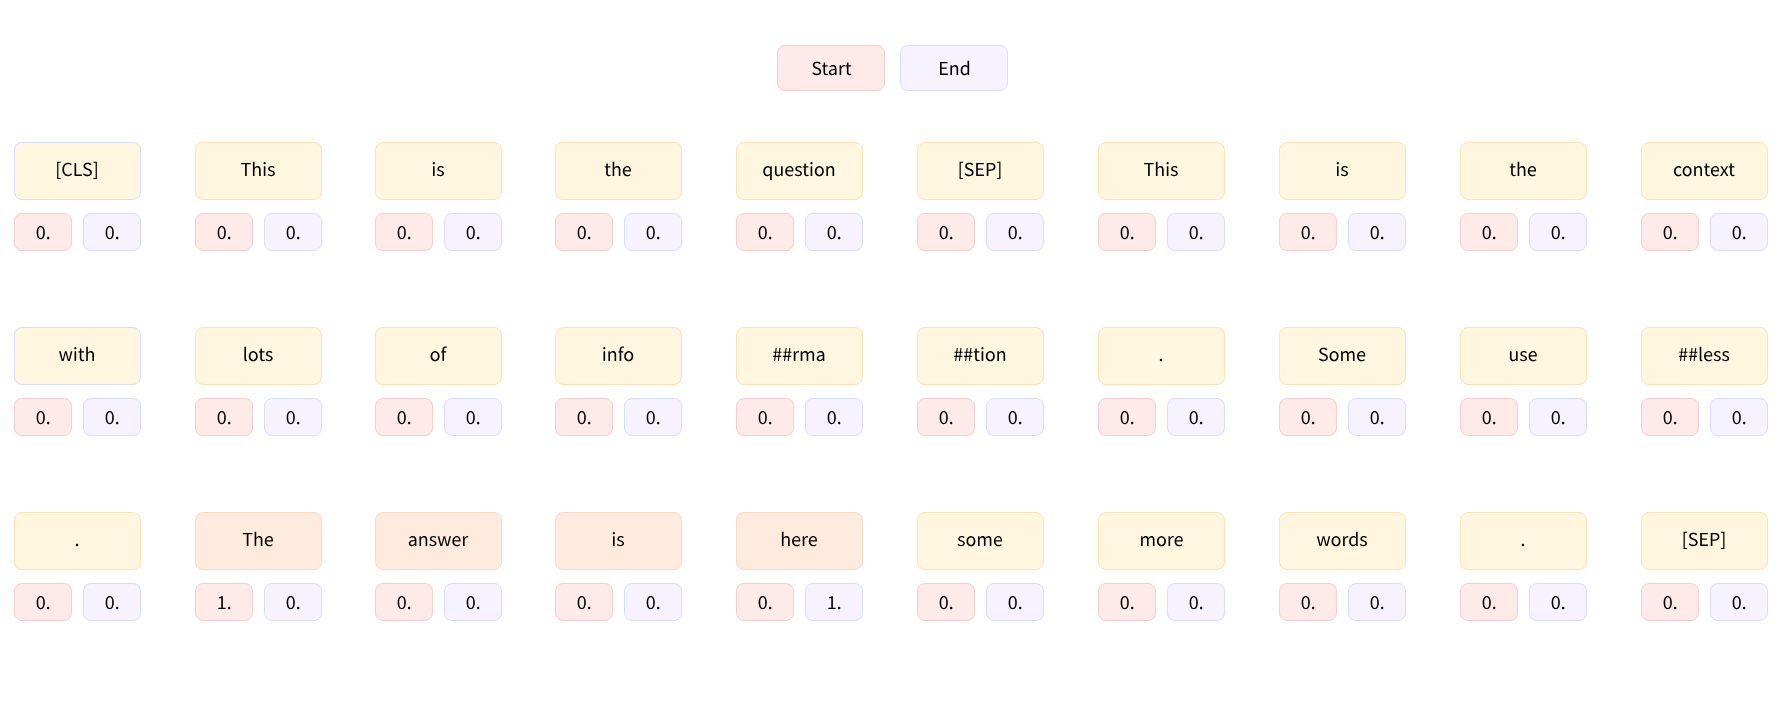
    - 所以数据预处理时候，需要根据 offset_mapping 来将原始的字符级别的答案映射到 token 级别的索引。
    - 还需要手动地将答案文本的在原文中的起始/结束位置映射到每个块的 token 索引，以构建答案标签 start_positions 和 end_positions。

# 1.准备数据
- 构建数据集
- 长文本分块为span
- 标记答案在span中的起始和结束位置
- 以batch进行分词,转为token ids,并且构建对应的标签

In [5]:
#查看原始数据构成情况
import json
with open('data/cmrc2018_dev.json', 'r', encoding='utf-8') as f:
    json_data = json.load(f)
    print(json_data['data'][0].keys())
    print(json_data['data'][0]['paragraphs'][0].keys())
    print(json_data['data'][0]['paragraphs'][0]['qas'][0].keys())
    print(json_data['data'][0]['paragraphs'][0]['qas'][0]['answers'][0].keys())


dict_keys(['paragraphs', 'id', 'title'])
dict_keys(['id', 'context', 'qas'])
dict_keys(['question', 'id', 'answers'])
dict_keys(['text', 'answer_start'])


第一层 'paragraphs', 'id', 'title'
第二层 在paragraphs中，每个paragraph包含'context', 'qas','id' 上下文和问题答案对
第三层 在qas中，每个qa包含'question', 'answers','id' 问题和答案对
第四层 在answers中，每个answer包含'answer_start', 'text'  也就是标签内容及其在context中的起始位置

### 1）构建数据集

In [6]:
# 加载数据集
from torch.utils.data import Dataset
import json

class CMRC2018(Dataset):
    def __init__(self, data_file):
        self.data = self.load_data(data_file)
    
    def load_data(self, data_file):
        Data={}
        with open(data_file, 'r', encoding='utf-8') as f:
            json_data = json.load(f) #加载整个json文件
            idx=0
            for item in json_data['data']:
                title = item['title']
                context=item['paragraphs'][0]['context'] #[0]是将字典从列表中提取出来
                for question in item['paragraphs'][0]['qas']:
                    question_id=question['id']
                    question_text=question['question']
                    text = [ans['text'] for ans in question['answers']]
                    answer_start = [ans['answer_start'] for ans in question['answers']]
                    Data[idx]={
                        'id':question_id,
                        'title':title,
                        'context':context,
                        'question':question_text,
                        'answers':{
                            'text': text,
                            'answer_start': answer_start
                        }
                    }
                    idx+=1
        return Data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [7]:
train_data = CMRC2018('data/cmrc2018_train.json')
valid_data = CMRC2018('data/cmrc2018_dev.json')
test_data = CMRC2018('data/cmrc2018_trial.json')

In [8]:
#尺寸和示例
print(f"训练集尺寸: {len(train_data)}")
print(f"验证集尺寸: {len(valid_data)}")
print(f"测试集尺寸: {len(test_data)}")
print(f"有哪些键: {next(iter(train_data))['answers'].keys()}")
print(f"示例: {next(iter(train_data))}")


训练集尺寸: 10142
验证集尺寸: 3219
测试集尺寸: 1002
有哪些键: dict_keys(['text', 'answer_start'])
示例: {'id': 'TRAIN_186_QUERY_0', 'title': '范廷颂', 'context': '范廷颂枢机（，），圣名保禄·若瑟（），是越南罗马天主教枢机。1963年被任为主教；1990年被擢升为天主教河内总教区宗座署理；1994年被擢升为总主教，同年年底被擢升为枢机；2009年2月离世。范廷颂于1919年6月15日在越南宁平省天主教发艳教区出生；童年时接受良好教育后，被一位越南神父带到河内继续其学业。范廷颂于1940年在河内大修道院完成神学学业。范廷颂于1949年6月6日在河内的主教座堂晋铎；及后被派到圣女小德兰孤儿院服务。1950年代，范廷颂在河内堂区创建移民接待中心以收容到河内避战的难民。1954年，法越战争结束，越南民主共和国建都河内，当时很多天主教神职人员逃至越南的南方，但范廷颂仍然留在河内。翌年管理圣若望小修院；惟在1960年因捍卫修院的自由、自治及拒绝政府在修院设政治课的要求而被捕。1963年4月5日，教宗任命范廷颂为天主教北宁教区主教，同年8月15日就任；其牧铭为「我信天主的爱」。由于范廷颂被越南政府软禁差不多30年，因此他无法到所属堂区进行牧灵工作而专注研读等工作。范廷颂除了面对战争、贫困、被当局迫害天主教会等问题外，也秘密恢复修院、创建女修会团体等。1990年，教宗若望保禄二世在同年6月18日擢升范廷颂为天主教河内总教区宗座署理以填补该教区总主教的空缺。1994年3月23日，范廷颂被教宗若望保禄二世擢升为天主教河内总教区总主教并兼天主教谅山教区宗座署理；同年11月26日，若望保禄二世擢升范廷颂为枢机。范廷颂在1995年至2001年期间出任天主教越南主教团主席。2003年4月26日，教宗若望保禄二世任命天主教谅山教区兼天主教高平教区吴光杰主教为天主教河内总教区署理主教；及至2005年2月19日，范廷颂因获批辞去总主教职务而荣休；吴光杰同日真除天主教河内总教区总主教职务。范廷颂于2009年2月22日清晨在河内离世，享年89岁；其葬礼于同月26日上午在天主教河内总教区总主教座堂举行。', 'question': '范廷颂是什么时候被任为主教的？', 'answers': {

因为参考答案可以有多个，所以答案文本 text 和位置 answer_start 都是列表。

In [9]:
from transformers import AutoTokenizer
from torch.utils.data import dataloader

checkpoint = "bert-base-chinese"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

d:\software\Anaconda\envs\LLM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2）分割为span
- span 是指文本中的一个连续的子序列，形式也是 [CLS] question [SEP] context [SEP]，对于同一个问题，上下文context可能会有多个span。所以question部分会是一致的。
- 对于抽取式问答任务，我们会将问题和上下文编码这个形式： [CLS] question [SEP] context [SEP]
- 上下文context是长文本，可能会超过模型的最大输入长度，所以我们需要对上下文进行分块。
    - 设置`max_length`为300，`stride`为50，即每个文本块的长度为300，两个相邻文本块之间的重合 token 数量为50。
    - 以下面例子说明：
        - 上下文context的长度为815，超过了模型的最大输入长度300，所以需要分块，分为了815/（300-50）取整数4块。
        - 也就是将一个长文本样本分为了四个样本。
- 还需要设置分词器参数 return_offsets_mapping=True，这样就可以运用快速分词器提供的 offset mapping 映射得到原始的对应的 token 索引。
- 返回了记录 token 到原文映射的 offset_mapping，
- 以及记录分块样本到原始样本映射的 overflow_to_sample_mapping。
- 由于问题长度不一样，但固定样本长度为300，所以分块后，每个问题的样本数量不一致。

- 输出：
    - 每个样本的输入_ids、token_type_ids、attention_mask、offset_mapping、overflow_to_sample_mapping
    - 并将长文本转为了多个span样本子序列。

In [ ]:
context = train_data[0]["context"]
question = train_data[0]["question"]
print(len(context))
inputs = tokenizer(
    question,
    context,
    max_length=300,
    truncation="only_second",# 只截断第二个序列，即上下文
    stride=50, # 两个相邻文本块之间的重合 token 数量
    return_overflowing_tokens=True,
)
for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

815
[CLS] 范 廷 颂 是 什 么 时 候 被 任 为 主 教 的 ？ [SEP] 范 廷 颂 枢 机 （ ， ） ， 圣 名 保 禄 · 若 瑟 （ ） ， 是 越 南 罗 马 天 主 教 枢 机 。 1963 年 被 任 为 主 教 ； 1990 年 被 擢 升 为 天 主 教 河 内 总 教 区 宗 座 署 理 ； 1994 年 被 擢 升 为 总 主 教 ， 同 年 年 底 被 擢 升 为 枢 机 ； 2009 年 2 月 离 世 。 范 廷 颂 于 1919 年 6 月 15 日 在 越 南 宁 平 省 天 主 教 发 艳 教 区 出 生 ； 童 年 时 接 受 良 好 教 育 后 ， 被 一 位 越 南 神 父 带 到 河 内 继 续 其 学 业 。 范 廷 颂 于 1940 年 在 河 内 大 修 道 院 完 成 神 学 学 业 。 范 廷 颂 于 1949 年 6 月 6 日 在 河 内 的 主 教 座 堂 晋 铎 ； 及 后 被 派 到 圣 女 小 德 兰 孤 儿 院 服 务 。 1950 年 代 ， 范 廷 颂 在 河 内 堂 区 创 建 移 民 接 待 中 心 以 收 容 到 河 内 避 战 的 难 民 。 1954 年 ， 法 越 战 争 结 束 ， 越 南 民 主 共 和 国 建 都 河 内 ， 当 时 很 多 天 主 教 神 职 人 员 逃 至 越 南 的 南 方 ， 但 范 廷 颂 仍 然 留 在 河 内 。 翌 年 [SEP]
[CLS] 范 廷 颂 是 什 么 时 候 被 任 为 主 教 的 ？ [SEP] 越 战 争 结 束 ， 越 南 民 主 共 和 国 建 都 河 内 ， 当 时 很 多 天 主 教 神 职 人 员 逃 至 越 南 的 南 方 ， 但 范 廷 颂 仍 然 留 在 河 内 。 翌 年 管 理 圣 若 望 小 修 院 ； 惟 在 1960 年 因 捍 卫 修 院 的 自 由 、 自 治 及 拒 绝 政 府 在 修 院 设 政 治 课 的 要 求 而 被 捕 。 1963 年 4 月 5 日 ， 教 宗 任 命 范 廷 颂 为 天 主 教 北 宁 教 区 主 教 ， 同 年 8 月 15 日 就 任 ； 其 牧 铭 为 「 我 信 天 主 的 爱 」 。 由 于 范 廷 颂 被 越 南 政 府 软 禁 差 不

In [16]:
# 以前4条样本为例
contexts = [train_data[idx]["context"] for idx in range(4)]
questions = [train_data[idx]["question"] for idx in range(4)]
#成对的形式进行编码,但只获得了问题和上下文的编码,没有获得问题和上下文的对应关系（答案的位置索引）
inputs = tokenizer(
    questions,
    contexts,
    max_length=300,
    truncation="only_second",# 只截断第二个序列，即上下文
    stride=50, # 两个相邻文本块之间的重合 token 数量
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

print(f"初始样本数: {len(contexts)}")
print(f"输入的键有: {list(inputs.keys())}")

print(f"按300长度分词后的样本数: {len(inputs['input_ids'])}")
for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

print(f"每个样本对应的原始样本索引: {inputs['overflow_to_sample_mapping']}")


初始样本数: 4
输入的键有: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping']
按300长度分词后的样本数: 14
[CLS] 范 廷 颂 是 什 么 时 候 被 任 为 主 教 的 ？ [SEP] 范 廷 颂 枢 机 （ ， ） ， 圣 名 保 禄 · 若 瑟 （ ） ， 是 越 南 罗 马 天 主 教 枢 机 。 1963 年 被 任 为 主 教 ； 1990 年 被 擢 升 为 天 主 教 河 内 总 教 区 宗 座 署 理 ； 1994 年 被 擢 升 为 总 主 教 ， 同 年 年 底 被 擢 升 为 枢 机 ； 2009 年 2 月 离 世 。 范 廷 颂 于 1919 年 6 月 15 日 在 越 南 宁 平 省 天 主 教 发 艳 教 区 出 生 ； 童 年 时 接 受 良 好 教 育 后 ， 被 一 位 越 南 神 父 带 到 河 内 继 续 其 学 业 。 范 廷 颂 于 1940 年 在 河 内 大 修 道 院 完 成 神 学 学 业 。 范 廷 颂 于 1949 年 6 月 6 日 在 河 内 的 主 教 座 堂 晋 铎 ； 及 后 被 派 到 圣 女 小 德 兰 孤 儿 院 服 务 。 1950 年 代 ， 范 廷 颂 在 河 内 堂 区 创 建 移 民 接 待 中 心 以 收 容 到 河 内 避 战 的 难 民 。 1954 年 ， 法 越 战 争 结 束 ， 越 南 民 主 共 和 国 建 都 河 内 ， 当 时 很 多 天 主 教 神 职 人 员 逃 至 越 南 的 南 方 ， 但 范 廷 颂 仍 然 留 在 河 内 。 翌 年 [SEP]
[CLS] 范 廷 颂 是 什 么 时 候 被 任 为 主 教 的 ？ [SEP] 越 战 争 结 束 ， 越 南 民 主 共 和 国 建 都 河 内 ， 当 时 很 多 天 主 教 神 职 人 员 逃 至 越 南 的 南 方 ， 但 范 廷 颂 仍 然 留 在 河 内 。 翌 年 管 理 圣 若 望 小 修 院 ； 惟 在 1960 年 因 捍 卫 修 院 的 自 由 、 自 治 及 拒 绝 政 府 在 修 院 设 政 治 课 的 要 求 而 被 捕

这里 4 个样本共被分块成了 14 个span子序列，其中前 4 个新样本来自于原始样本 0，接着 3 个新样本来自于样本 1 …等等。

### 3）答案位置映射：char index → token index
- span处理后只有上下文和问题的编码，训练还需要答案。
- 将答案在原始文本中的字符级位置（char-level）”，映射成“模型输入 token 序列中的起止 token 索引（token-level）
    - 需要注意的是，因为原来的上下文被进行了分块，所以答案的 token 索引也需要根据分块后的上下文进行调整。
- 用到了 `inputs.sequence_ids()` 方法，它可以返回每个 token 所属的序列 ID（0 或 1）。其中 0 对应 question，1 对应 context。
- 构建答案标签 start_positions 和 end_positions。标签就是起始和结束 token 的索引；
- 对于不包含答案或只有部分答案的span，对应的标签都为 start_position = end_position = 0（即 [CLS]）。
- 遍历每个span子序列，判断是否有答案落在这个span子序列中。
    - 如果有，记录下答案在span子序列中的起始和结束 token 索引。
    - 如果没有，将 start_position = end_position = 0。

- 输出 start_positions 和 end_positions 两个列表

In [17]:
answers = [train_data[idx]["answers"] for idx in range(4)]
start_positions = []
end_positions = []

for i, offset in enumerate(inputs["offset_mapping"]): #遍历每个span子序列
    #第i个样本来自于哪一个原始样本
    sample_idx = inputs["overflow_to_sample_mapping"][i]
    #以原始样本的索引来取对应的答案
    answer = answers[sample_idx]
        # 答案的起始字符索引
    start_char = answer["answer_start"][0]
        # 答案的结束字符索引
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    #sequence_ids：区分 question / context
    # 0 表示 question，1 表示 context
    sequence_ids = inputs.sequence_ids(i)

    #________定位 context 在 token 序列中的范围，出现第一个 1 时为 context 开始
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx 

    # 出现最后一个 1 时为 context 结束
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1
    ###此时知道了序列中 每个context 的context_start, context_end的token索引



    # 判断：答案是否完整落在这个 span 里
    if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        #答案在当前 span 内 → 精确找 token 起点
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

print(start_positions)
print(end_positions)

[47, 0, 0, 0, 53, 0, 0, 100, 0, 0, 0, 0, 61, 0]
[48, 0, 0, 0, 70, 0, 0, 124, 0, 0, 0, 0, 106, 0]


In [ ]:
#查看第一个span子序列的答案
idx = 0
sample_idx = inputs["overflow_to_sample_mapping"][idx] #原始样本索引
answer = answers[sample_idx]["text"][0]#原始样本的答案
print(f"Theoretical answer: {answer}")
#查看手动标注的答案
start=start_positions[idx]
end=end_positions[idx]
labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end + 1])
print(f"Labeled answer: {labeled_answer}")


Theoretical answer: 1963年
Labeled answer: 1963 年


###  4)批量处理
- 对每个样本，将其答案在上下文中的起始和结束位置，映射到token序列中的索引
- 以batch进行处理，提高效率
- 输出：问题和上下文的编码，以及答案的起始和结束 token 索引的tensor

In [ ]:
import torch
from torch.utils.data import DataLoader

max_length = 384
stride = 128

def train_collate_fn(batch_samples):
    # 对batch中的每个样本，将其答案在上下文中的起始和结束位置，映射到token序列中的索引
    batch_questions = []
    batch_contexts = []
    batch_answers = []
    for sample in batch_samples:
        question = sample["question"]
        context = sample["context"]
        answer = sample["answers"]
        batch_questions.append(question)
        batch_contexts.append(context)
        batch_answers.append(answer)

    batch_data = tokenizer(
        batch_questions,
        batch_contexts,
        max_length=max_length,
        stride=stride,
        padding="max_length",
        truncation="only_second",
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        return_tensors="pt")



    offset_mapping = batch_data.pop("offset_mapping") # 移除offset_mapping,后续用于将token索引映射回原始文本中的位置
    sample_mapping = batch_data.pop("overflow_to_sample_mapping") # 移除sample_mapping,后续用于将token索引映射回原始样本中的位置
    
    start_positions = []
    end_positions = []
    for i, offset in enumerate(offset_mapping):
        sample_index = sample_mapping[i]
        answer = batch_answers[sample_index]
        start_char = answer['answer_start'][0]
        end_char = answer['answer_start'][0] + len(answer['text'][0])
        sequence_ids = batch_data.sequence_ids(i)
        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1
        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)
    return batch_data, torch.tensor(start_positions), torch.tensor(end_positions)

train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=train_collate_fn)



In [ ]:
# 查看一个batch的数据
batch_X, batch_Start, batch_End = next(iter(train_dataloader))
print('batch_X shape:', {k: v.shape for k, v in batch_X.items()})
print('batch_Start shape:', batch_Start.shape)
print('batch_End shape:', batch_End.shape)
print(batch_X)
print(batch_Start)
print(batch_End)

print('train set size: ', )
print(len(train_data), '->', sum([batch_data['input_ids'].shape[0] for batch_data, _, _ in train_dataloader]))

batch_X shape: {'input_ids': torch.Size([10, 384]), 'token_type_ids': torch.Size([10, 384]), 'attention_mask': torch.Size([10, 384])}
batch_Start shape: torch.Size([10])
batch_End shape: torch.Size([10])
{'input_ids': tensor([[ 101, 8325, 7339,  ..., 6822, 6121,  102],
        [ 101, 8325, 7339,  ...,    0,    0,    0],
        [ 101, 2140, 1187,  ..., 2813, 6832,  102],
        ...,
        [ 101,  517, 1771,  ..., 1469, 2341,  102],
        [ 101,  517, 1771,  ..., 4638,  519,  102],
        [ 101,  517, 1771,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,

经过分块操作后，4个原始样本被切分成了10个新样本，整个训练集的大小从 10142 增长到了 18960。

### 5)验证集和测试集的分块
对于验证集和测试集，我们也需要进行分块操作，但关注的不是预测出的标签序列，而是最终的答案文本，
在验证 / 测试阶段，模型的“预测目标”不是 token 级标签本身，而是它们所确定的 答案文本

1.记录每个原始样本被分块成了哪几个新样本，从而合并对应的预测结果；

2.在 offset mapping 中标记问题的对应 token，从而在后处理阶段可以区分哪些位置的 token 来自于上下文。

In [29]:
# 测试和验证集的dataloader
def test_collote_fn(batch_samples):
    batch_id, batch_question, batch_context = [], [], []
    for sample in batch_samples:
        batch_id.append(sample['id'])
        batch_question.append(sample['question'])
        batch_context.append(sample['context'])
    batch_data = tokenizer(
        batch_question,
        batch_context,
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length", 
        return_tensors="pt"
    )
    
    offset_mapping = batch_data.pop('offset_mapping').numpy().tolist()
    sample_mapping = batch_data.pop('overflow_to_sample_mapping')
    example_ids = []

    for i in range(len(batch_data['input_ids'])):
        sample_idx = sample_mapping[i]
        example_ids.append(batch_id[sample_idx])

        sequence_ids = batch_data.sequence_ids(i)
        offset = offset_mapping[i]
        offset_mapping[i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]
    return batch_data, offset_mapping, example_ids

valid_dataloader = DataLoader(valid_data, batch_size=8, shuffle=False, collate_fn=test_collote_fn)

In [31]:
batch_X, offset_mapping, example_ids = next(iter(valid_dataloader))
print('batch_X shape:', {k: v.shape for k, v in batch_X.items()})
print(example_ids[5])

print('valid set size: ')
print(len(valid_data), '->', sum([batch_data['input_ids'].shape[0] for batch_data, _, _ in valid_dataloader]))

batch_X shape: {'input_ids': torch.Size([16, 384]), 'token_type_ids': torch.Size([16, 384]), 'attention_mask': torch.Size([16, 384])}
DEV_0_QUERY_2
valid set size: 
3219 -> 6254


# 2.模型训练
- 构造模型
    - 使用AutoModelForQuestionAnswering 函数来构建模型。


    - 采用继承 Transformers 库预训练模型的方式来手工构建模型。 √
        - 输出的是每个span中每个token可能作为答案起始位置的分数和作为答案结束位置的分数
        - 利用Bert将每一个 token 都编码为语义向量，然后将输出序列送入到一个包含 2 个神经元的线性全连接层中，输出分别表示每个 token 为答案起始、结束位置的分数，也就是seq中每一个 token都有可能是答案的起始位置或结束位置，每个 token 作为答案起始位置的分数和作为答案结束位置的分数分别对应了模型输出的两个维度。

        - 分割输出序列，将每个 token 的输出向量分别作为起始位置、结束位置的分数
        - 维度变化为 输入[8, 384]，经过线性全连接层后，输出为[8, 384, 2]，拆分后为[8, 384]和[8, 384]

In [32]:
from torch import nn
from transformers import AutoConfig
from transformers import BertPreTrainedModel, BertModel

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

class BertForExtractiveQA(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.post_init() # 初始化模型参数
    
    def forward(self, x):
        bert_output = self.bert(**x) # 输入x 包含input_ids, attention_mask, token_type_ids
        sequence_output = bert_output.last_hidden_state
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        start_logits, end_logits = logits.split(1, dim=-1) # 分割为开始位置和结束位置的logits
        start_logits = start_logits.squeeze(-1).contiguous() # 移除最后一个维度并保持内存连续
        end_logits = end_logits.squeeze(-1).contiguous() # 移除最后一个维度并保持内存连续

        return start_logits, end_logits
        
config = AutoConfig.from_pretrained(checkpoint)
model = BertForExtractiveQA.from_pretrained(checkpoint, config=config).to(device)
print(model)


Using cuda device


Some weights of BertForExtractiveQA were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForExtractiveQA(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

测试下模型
输出就是两个tensor，每个tensor的shape为[8, 384]，分别表示每个token作为答案起始位置的分数和作为答案结束位置的分数


In [39]:

batch_X, _, _ = next(iter(train_dataloader))
batch_X = batch_X.to(device)
start_outputs, end_outputs = model(batch_X)
print('batch_X shape:', {k: v.shape for k, v in batch_X.items()})
print('start_outputs shape', start_outputs.shape)
print('end_outputs shape', end_outputs.shape)


batch_X shape: {'input_ids': torch.Size([8, 384]), 'token_type_ids': torch.Size([8, 384]), 'attention_mask': torch.Size([8, 384])}
start_outputs shape torch.Size([8, 384])
end_outputs shape torch.Size([8, 384])


###  1）训练循环：
判断每个 token 是否为答案的起始/结束位置，本质上就是在长度为seq上的分类问题，因此这里我们分别在起始和结束的输出上运用交叉熵来计算损失，然后取两个损失的平均值作为模型的整体损失：

In [49]:
from tqdm.auto import tqdm

def train_loop(dataloader, model, loss_fn, optimizer, lr_scheduler, epoch, total_loss):
    progress_bar = tqdm(range(len(dataloader)))
    progress_bar.set_description(f'loss: {0:>7f}')
    finish_batch_num = (epoch-1) * len(dataloader)
    
    model.train()
    for batch, (X, start_pos, end_pos) in enumerate(dataloader, start=1):
        X, start_pos, end_pos = X.to(device), start_pos.to(device), end_pos.to(device)
        start_pred, end_pred = model(X)
        start_loss = loss_fn(start_pred, start_pos)
        end_loss = loss_fn(end_pred, end_pos)
        loss = (start_loss + end_loss) / 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        progress_bar.set_description(f'loss: {total_loss/(finish_batch_num + batch):>7f}')
        progress_bar.update(1)
    return total_loss

### 2）后处理
怎么将模型的输出转换为答案文本

- 直接基于 logits 值来估计答案分数，计算 logits 值的和（因为<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>log</mi>
  <mo data-mjx-texclass="NONE">&#x2061;</mo>
  <mo stretchy="false">(</mo>
  <mi>a</mi>
  <mi>b</mi>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <mi>log</mi>
  <mo data-mjx-texclass="NONE">&#x2061;</mo>
  <mo stretchy="false">(</mo>
  <mi>a</mi>
  <mo stretchy="false">)</mo>
  <mo>+</mo>
  <mi>log</mi>
  <mo data-mjx-texclass="NONE">&#x2061;</mo>
  <mo stretchy="false">(</mo>
  <mi>b</mi>
  <mo stretchy="false">)</mo>
</math>)
- 其次，为了减少计算量，我们不再为所有可能的 (start_token, end_token) 对打分，而是遍历数据集中的样本,只计算 logits 值最高的前 n_best 个 token 组成的对。

在将预测结果转换为文本之前，我们还需要知道每个样本被分块为了哪几个新样本，从而汇总对应的预测结果，因此下面先构造一个记录样本 ID 到新样本索引的映射：

In [52]:

#以未训练的模型为例
small_eval_set = [valid_data[idx] for idx in range(12)]

eval_set = DataLoader(small_eval_set, batch_size=4, shuffle=False, collate_fn=test_collote_fn)


all_example_ids = []
all_offset_mapping = []
for _, offset_mapping, example_ids in eval_set:
    all_example_ids += example_ids
    all_offset_mapping += offset_mapping

import collections
example_to_features = collections.defaultdict(list)
for idx, feature_id in enumerate(all_example_ids):
    example_to_features[feature_id].append(idx)

print(example_to_features) # 每个样本被分块为了哪些新样本

defaultdict(<class 'list'>, {'DEV_0_QUERY_0': [0, 1], 'DEV_0_QUERY_1': [2, 3], 'DEV_0_QUERY_2': [4, 5], 'DEV_1_QUERY_0': [6, 7], 'DEV_1_QUERY_1': [8, 9], 'DEV_1_QUERY_2': [10, 11], 'DEV_1_QUERY_3': [12, 13], 'DEV_2_QUERY_0': [14, 15], 'DEV_2_QUERY_1': [16, 17], 'DEV_2_QUERY_2': [18, 19], 'DEV_3_QUERY_0': [20], 'DEV_3_QUERY_1': [21]})


In [62]:
start_logits = []
end_logits = []

model.eval()
for batch_data, _, _ in eval_set:
    batch_data = batch_data.to(device)
    with torch.no_grad():
        outputs = model(batch_data)
    #将输出的第二个tensor转换为numpy数组
    start_logits.append(outputs[0].cpu().numpy())
    end_logits.append(outputs[1].cpu().numpy())

import numpy as np
start_logits = np.concatenate(start_logits)
end_logits = np.concatenate(end_logits)

接下来我们只需要遍历数据集中的样本，首先汇总由其分块出的新样本的预测结果，然后取出每个新样本最高的前 n_best 个起始/结束 logits 值，最后评估对应的 token 片段为答案的分数（这里我们还通过限制答案的最大长度来进一步减小计算量）：

In [63]:
n_best = 20
max_answer_length = 30
theoretical_answers = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in small_eval_set
]
predicted_answers = []

for example in small_eval_set:
    example_id = example["id"]
    context = example["context"]
    answers = []

    for feature_index in example_to_features[example_id]:
        start_logit = start_logits[feature_index]
        end_logit = end_logits[feature_index]
        offsets = all_offset_mapping[feature_index]

        start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
        end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
        for start_index in start_indexes:
            for end_index in end_indexes:
                if offsets[start_index] is None or offsets[end_index] is None:
                    continue
                if (end_index < start_index or end_index - start_index + 1 > max_answer_length):
                    continue
                answers.append(
                    {
                        "start": offsets[start_index][0],
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                )
    if len(answers) > 0:
        best_answer = max(answers, key=lambda x: x["logit_score"])
        predicted_answers.append({
            "id": example_id, 
            "prediction_text": best_answer["text"], 
            "answer_start": best_answer["start"]
        })
    else:
        predicted_answers.append({
            "id": example_id, 
            "prediction_text": "", 
            "answer_start": 0
        })

In [64]:
for pred, label in zip(predicted_answers, theoretical_answers):
    print(pred['id'])
    print('pred:', pred['prediction_text'])
    print('label:', label['answers']['text'])

DEV_0_QUERY_0
pred: 改编的新增模式。本作中共
label: ['光荣和ω-force', '光荣和ω-force', '光荣和ω-force']
DEV_0_QUERY_1
pred: 改编的新增模式。本作中共
label: ['村雨城', '村雨城', '任天堂游戏谜之村雨城']
DEV_0_QUERY_2
pred: 改编的新增模式。本作中共
label: ['「战史演武」&「争霸演武」', '「战史演武」&「争霸演武」', '「战史演武」&「争霸演武」']
DEV_1_QUERY_0
pred: 的演奏方法。常用的节奏型称
label: ['大陆传统器乐及戏曲里面常用的打击乐记谱方法', '大陆传统器乐及戏曲里面常用的打击乐记谱方法', '大陆传统器乐及戏曲里面常用的打击乐记谱方法']
DEV_1_QUERY_1
pred: 的演奏方法。常用的节奏型称
label: ['锣鼓点', '锣鼓点', '锣鼓点']
DEV_1_QUERY_2
pred: 的演奏方法。常用的节奏型称
label: ['依照角色行当的身份、性格、情绪以及环境，配合相应的锣鼓点。', '依照角色行当的身份、性格、情绪以及环境，配合相应的锣鼓点。', '依照角色行当的身份、性格、情绪以及环境，配合相应的锣鼓点']
DEV_1_QUERY_3
pred: 「鼓佬」，其职
label: ['鼓、锣、钹和板', '鼓、锣、钹和板', '鼓、锣、钹和板']
DEV_2_QUERY_0
pred: 326公里，共
label: ['364.6公里', '364.6公里', '364.6公里']
DEV_2_QUERY_1
pred: 326公里，共
label: ['三茂铁路股份有限公司', '三茂铁路股份有限公司', '三茂铁路股份有限公司']
DEV_2_QUERY_2
pred: 326公里，共
label: ['1903年', '1903年', '1903年']
DEV_3_QUERY_0
pred: 角沟、潍坊、
label: ['山东省北部环渤海地区', '山东省北部环渤海地区', '山东省北部环渤海地区']
DEV_3_QUERY_1
pred: 角沟、潍坊、
label: ['11.42亿元', '11.42亿元', '11.42亿元']


因为没有训练，所以模型的预测结果都是随机的，我们可以看到预测的答案与真实答案完全不同。

在成功获取到预测的答案片段之后，就可以对模型的性能进行评估了。这里我们对 CMRC 2018 自带的评估脚本进行修改，使其支持本文模型的输出格式。
为了方便，我们将修改后的脚本保存为 `evaluate.py`。

In [66]:
import collections
from evaluate import evaluate

n_best = 20
max_answer_length = 30

def test_loop(dataloader, dataset, model):
    all_example_ids = []
    all_offset_mapping = []
    for _, offset_mapping, example_ids in dataloader:
        all_example_ids += example_ids
        all_offset_mapping += offset_mapping
    example_to_features = collections.defaultdict(list)
    for idx, feature_id in enumerate(all_example_ids):
        example_to_features[feature_id].append(idx)

    start_logits = []
    end_logits = []
    model.eval()
    for batch_data, _, _ in tqdm(dataloader):
        batch_data = batch_data.to(device)
        with torch.no_grad():
            outputs = model(**batch_data)
        start_logits.append(outputs.start_logits.cpu().numpy())
        end_logits.append(outputs.end_logits.cpu().numpy())
    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    
    theoretical_answers = [
        {"id": dataset[s_idx]["id"], "answers": dataset[s_idx]["answers"]} for s_idx in range(len(dataset))
    ]
    predicted_answers = []
    for s_idx in tqdm(range(len(dataset))):
        example_id = dataset[s_idx]["id"]
        context = dataset[s_idx]["context"]
        answers = []
        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = all_offset_mapping[feature_index]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    if (end_index < start_index or end_index-start_index+1 > max_answer_length):
                        continue
                    answers.append({
                        "start": offsets[start_index][0], 
                        "text": context[offsets[start_index][0] : offsets[end_index][1]], 
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    })
        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append({
                "id": example_id, 
                "prediction_text": best_answer["text"], 
                "answer_start": best_answer["start"]
            })
        else:
            predicted_answers.append({
                "id": example_id, 
                "prediction_text": "", 
                "answer_start": 0
            })
    result = evaluate(predicted_answers, theoretical_answers)
    print(f"F1: {result['f1']:>0.2f} EM: {result['em']:>0.2f} AVG: {result['avg']:>0.2f}\n")
    return result

d:\software\Anaconda\envs\LLM\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\models--bert-base-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


### 保存模型

In [69]:
from transformers import  get_scheduler
from torch.optim import AdamW

learning_rate = 1e-5
epoch_num = 3

optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=epoch_num*len(train_dataloader),
)

total_loss = 0.
best_avg_score = 0.
for t in range(epoch_num):
    print(f"Epoch {t+1}/{epoch_num}\n-------------------------------")
    total_loss = train_loop(train_dataloader, model, loss_fn, optimizer, lr_scheduler, t+1, total_loss)
    valid_scores = test_loop(valid_dataloader, valid_data, model, mode='Valid')
    avg_score = valid_scores['avg']
    if avg_score > best_avg_score:
        best_avg_score = avg_score
        print('saving new weights...\n')
        torch.save(model.state_dict(), f'epoch_{t+1}_valid_avg_{avg_score:0.4f}_model_weights.bin')
print("Done!")

Epoch 1/3
-------------------------------


loss: 6.013329:   0%|          | 5/2536 [00:06<57:33,  1.36s/it]  

KeyboardInterrupt: 

# 3.模型评估
- 汇报其在测试集上的性能，
- 并且将模型的预测结果保存到文件中。

In [ ]:
model.load_state_dict(torch.load('epoch_2_valid_avg_75.2441_model_weights.bin'))

model.eval()
with torch.no_grad():
    print('evaluating on test set...')
    all_example_ids = []
    all_offset_mapping = []
    for _, offset_mapping, example_ids in test_dataloader:
        all_example_ids += example_ids
        all_offset_mapping += offset_mapping
    example_to_features = collections.defaultdict(list)
    for idx, feature_id in enumerate(all_example_ids):
        example_to_features[feature_id].append(idx)

    start_logits = []
    end_logits = []
    model.eval()
    for batch_data, _, _ in tqdm(test_dataloader):
        batch_data = batch_data.to(device)
        pred_start_logits, pred_end_logit = model(batch_data)
        start_logits.append(pred_start_logits.cpu().numpy())
        end_logits.append(pred_end_logit.cpu().numpy())
    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    
    theoretical_answers = [
        {"id": test_data[s_idx]["id"], "answers": test_data[s_idx]["answers"]} for s_idx in range(len(test_dataloader))
    ]
    predicted_answers = []
    save_resluts = []
    for s_idx in tqdm(range(len(test_data))):
        example_id = test_data[s_idx]["id"]
        context = test_data[s_idx]["context"]
        title = test_data[s_idx]["title"]
        question = test_data[s_idx]["question"]
        labels = test_data[s_idx]["answers"]
        answers = []
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = all_offset_mapping[feature_index]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    if (end_index < start_index or end_index-start_index+1 > max_answer_length):
                        continue
                    answers.append({
                        "start": offsets[start_index][0], 
                        "text": context[offsets[start_index][0] : offsets[end_index][1]], 
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    })
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append({
                "id": example_id, 
                "prediction_text": best_answer["text"], 
                "answer_start": best_answer["start"]
            })
            save_resluts.append({
                "id": example_id, 
                "title": title, 
                "context": context, 
                "question": question, 
                "answers": labels, 
                "prediction_text": best_answer["text"], 
                "answer_start": best_answer["start"]
            })
        else:
            predicted_answers.append({
                "id": example_id, 
                "prediction_text": "", 
                "answer_start": 0
            })
            save_resluts.append({
                "id": example_id, 
                "title": title, 
                "context": context, 
                "question": question, 
                "answers": labels, 
                "prediction_text": "", 
                "answer_start": 0
            })
    eval_result = evaluate(predicted_answers, theoretical_answers)
    print(f"F1: {eval_result['f1']:>0.2f} EM: {eval_result['em']:>0.2f} AVG: {eval_result['avg']:>0.2f}\n")
    print('saving predicted results...')
    with open('test_data_pred.json', 'wt', encoding='utf-8') as f:
        for example_result in save_resluts:
            f.write(json.dumps(example_result, ensure_ascii=False) + '\n')